### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
from qdev_wrappers.alazar_controllers.ATSChannelController import ATSChannelController
from qdev_wrappers.alazar_controllers.alazar_channel import AlazarChannel
#import qcodes.instrument_drivers.AlazarTech.acq_helpers as helpers
from qcodes.station import Station

import logging
logging.basicConfig(level=logging.INFO)

User schema at C:\Users\Jens/qcodesrc_schema.json not found.User settings won't be validated


In [3]:
from qcodes.instrument.parameter import ManualParameter
import qcodes

NB: See ATS9360 example notebook for general commands 

In [4]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '6.0.0',
 'asopc_type': '1779729248',
 'bits_per_sample': 12,
 'driver_version': '6.0.0',
 'firmware': None,
 'latest_cal_date': '25-01-17',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970396',
 'vendor': 'AlazarTech'}

In [5]:
# Configure all settings in the Alazar card
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=1_000_000_000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=160,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

## Example 1

Pulls the raw data the alazar acquires averaged over records and buffers.

In [7]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to. Explicitly pass the default options to the Alazar.
# Dont integrate over samples but avarage over records
myctrl = ATSChannelController(name='my_controller', alazar_name='Alazar')

Put the Alazar and the controller in a station so we ensure that all parameters are captured

In [8]:
station = qc.Station(alazar, myctrl)

INFO:root:Snapshot: Could not update parameter: mode
INFO:root:Snapshot: Could not update parameter: samples_per_record
INFO:root:Snapshot: Could not update parameter: records_per_buffer
INFO:root:Snapshot: Could not update parameter: buffers_per_acquisition
INFO:root:Snapshot: Could not update parameter: channel_selection
INFO:root:Snapshot: Could not update parameter: transfer_offset
INFO:root:Snapshot: Could not update parameter: external_startcapture
INFO:root:Snapshot: Could not update parameter: enable_record_headers
INFO:root:Snapshot: Could not update parameter: alloc_buffers
INFO:root:Snapshot: Could not update parameter: fifo_only_streaming
INFO:root:Snapshot: Could not update parameter: interleave_samples
INFO:root:Snapshot: Could not update parameter: get_processed_data
INFO:root:Snapshot: Could not update parameter: allocated_buffers
INFO:root:Snapshot: Could not update parameter: buffer_timeout


This controller is designed to be highlevel and it is not possible to directly set number of records, buffers and samples. The number of samples is indirecly controlled by the integration time and integration delay and the number of averages controls the number of buffers and records acquired

In [9]:
myctrl.int_time.set?

In [10]:
myctrl.int_time._latest

{'raw_value': None,
 'ts': datetime.datetime(2017, 11, 21, 10, 59, 39, 708078),
 'value': None}

In [11]:
myctrl.int_delay(2e-7)
myctrl.int_time(2e-6)
print(myctrl.samples_per_record())
#myctrl.num_avg(1000)

INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 200.0 samples round up to 256
INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 2200.0 samples round up to 4096


4096


Per default the controller does not have any channels assiated with it.

In [12]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [])

# 1D samples trace

Lets define a channel were we avarege over buffers and records but not over samples. This will give us a time series with a x axis defined by int_time, int_delay and the sampling rate. First we create a channel and set the relevant parameters. We may choose to append the channel to the controllers build in list of channels for future reference.

In [13]:
chan1 = AlazarChannel(myctrl, 'mychan', demod=False, integrate_samples=False)
myctrl.channels.append(chan1)

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#018_{name}_10-59-48'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (4096,)
acquired at 2017-11-21 10:59:48


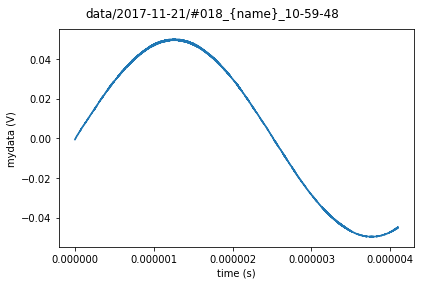

In [14]:
chan1.num_averages(1000)

chan1.alazar_channel('A')
chan1.prepare_channel()

# Measure this 
data1 = qc.Measure(chan1.data).run()
qc.MatPlot(data1.my_controller_mychan_data)

We can measure the time taken to do a measurement

In [15]:
%%time
qc.Measure(chan1.data).run()

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#019_{name}_10-59-49'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (4096,)
acquired at 2017-11-21 10:59:49
Wall time: 222 ms


DataSet:
   location = 'data/2017-11-21/#019_{name}_10-59-49'
   <Type>   | <array_id>                | <array.name> | <array.shape>
   Measured | my_controller_mychan_data | data         | (4096,)

## Demodulation

We may optionally chose to demodulate the data that we acquire using a software demodulator

In [16]:
chan1d = AlazarChannel(myctrl, 'mychan_demod_1', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d)

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#020_{name}_10-59-50'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mychan_demod_1_data | data         | (4096,)
acquired at 2017-11-21 10:59:51


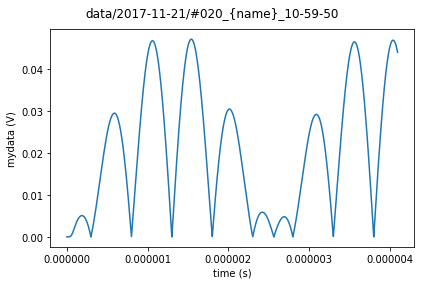

In [17]:
chan1d.num_averages(1000)

chan1d.alazar_channel('A')
chan1d.demod_freq(1e6)
chan1d.demod_type('magnitude')

chan1d.prepare_channel()

# Measure this 
data1d = qc.Measure(chan1d.data).run()
qc.MatPlot(data1d.my_controller_mychan_demod_1_data)

We are free to add more demodulators with different frequencies

In [18]:
chan1d2 = AlazarChannel(myctrl, 'mychan_demod_2', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d2)

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#021_{name}_10-59-51'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mychan_demod_2_data | data         | (4096,)
acquired at 2017-11-21 10:59:51


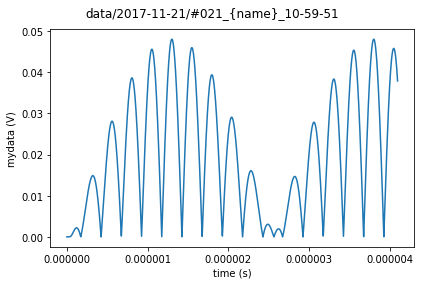

In [19]:
chan1d2.num_averages(1000)

chan1d2.alazar_channel('A')
chan1d2.demod_freq(2e6)
chan1d2.demod_type('magnitude')

chan1d2.prepare_channel()

# Measure this 
data1d = qc.Measure(chan1d2.data).run()
qc.MatPlot(data1d.my_controller_mychan_demod_2_data)

In [20]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATSChannelController: my_controller>])

We can get the data from multiple chanels in one provided that the shape (buffers,records,samples) is the same, The time overhead is fairly small as we are only capturing the data once.

In [21]:
%%time
data = qc.Measure(myctrl.channels.data).run()

c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#022_{name}_10-59-52'
   <Type>   | <array_id>                        | <array.name>                      | <array.shape>
   Setpoint | time_set                          | time                              | (4096,)
   Measured | my_controller_mychan_data         | my_controller_mychan_data         | (4096,)
   Measured | my_controller_mychan_demod_1_data | my_controller_mychan_demod_1_data | (4096,)
   Measured | my_controller_mychan_demod_2_data | my_controller_mychan_demod_2_data | (4096,)
acquired at 2017-11-21 10:59:52
Wall time: 263 ms


c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#023_{name}_10-59-53'
   <Type>   | <array_id>                        | <array.name>                      | <array.shape>
   Setpoint | time_set                          | time                              | (4096,)
   Measured | my_controller_mychan_data         | my_controller_mychan_data         | (4096,)
   Measured | my_controller_mychan_demod_1_data | my_controller_mychan_demod_1_data | (4096,)
   Measured | my_controller_mychan_demod_2_data | my_controller_mychan_demod_2_data | (4096,)
acquired at 2017-11-21 10:59:53


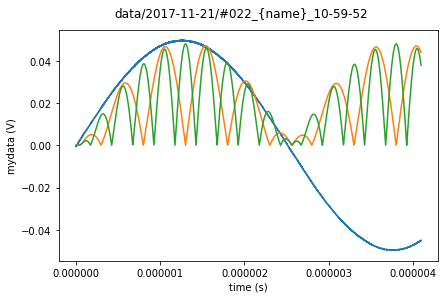

In [22]:
data1 = qc.Measure(myctrl.channels.data).run()
plot = qc.MatPlot()
plot.add(data.my_controller_mychan_data)
plot.add(data.my_controller_mychan_demod_1_data)
plot.add(data.my_controller_mychan_demod_2_data)

# 1D records trace

We can also do a 1D trace of records

In [23]:
chan2 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_records=False)
myctrl.channels.append(chan2)

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#024_{name}_10-59-53'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_data | data         | (55,)
acquired at 2017-11-21 10:59:54


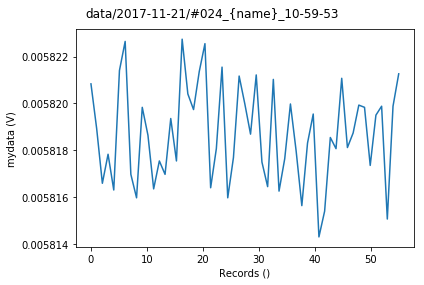

In [24]:
chan2.num_averages(100)
chan2.records_per_buffer(55)
chan2.alazar_channel('A')

chan2.prepare_channel()

# Measure this 
data2 = qc.Measure(myctrl.channels[-1].data).run()
qc.MatPlot(data2.my_controller_myrecchan_data)

Again it is posssible to demodulate the data

In [25]:
chan2d = AlazarChannel(myctrl, 'myrecchan_D', demod=True, average_records=False)
myctrl.channels.append(chan2d)

In [26]:
print(myctrl.int_delay())
print(myctrl.int_time())

2e-07
2e-06


In [27]:
myctrl.int_time._latest

{'raw_value': 2e-06,
 'ts': datetime.datetime(2017, 11, 21, 10, 59, 54, 544325),
 'value': 2e-06}

In [28]:
chan2d.alazar_channel('A')
chan2d.demod_freq(1e6)
chan2d.demod_type('magnitude')

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#025_{name}_10-59-55'
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_D_data | data         | (55,)
acquired at 2017-11-21 10:59:55


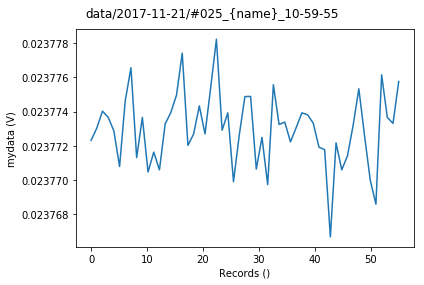

In [29]:
chan2d.num_averages(100)
chan2d.records_per_buffer(55)
chan2d.alazar_channel('A')

chan2d.prepare_channel()

# Measure this 
data2d = qc.Measure(myctrl.channels[-1].data).run()
qc.MatPlot(data2d.my_controller_myrecchan_D_data)

In [30]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATSChannelController: my_controller>])

In [31]:
myctrl.channels[-2:]

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, (<AlazarChannel: my_controller_myrecchan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATSChannelController: my_controller>))

c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#026_{name}_10-59-55'
   <Type>   | <array_id>                     | <array.name>                   | <array.shape>
   Setpoint | records_set                    | records                        | (55,)
   Measured | my_controller_myrecchan_data   | my_controller_myrecchan_data   | (55,)
   Measured | my_controller_myrecchan_D_data | my_controller_myrecchan_D_data | (55,)
acquired at 2017-11-21 10:59:56


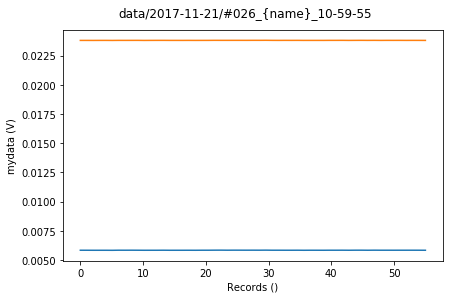

In [32]:
data = qc.Measure(myctrl.channels[-2:].data).run()
plot = qc.MatPlot()
plot.add(data.my_controller_myrecchan_data )
plot.add(data.my_controller_myrecchan_D_data)

# 1D Buffer trace

We can also do a 1D trace over buffers in the same way

In [33]:
chan3 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_buffers=False)
myctrl.channels.append(chan3)


INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#027_{name}_10-59-56'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_data | data         | (100,)
acquired at 2017-11-21 10:59:56
10000


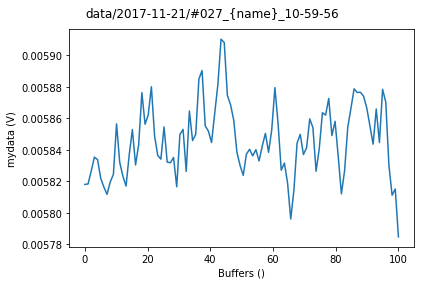

In [34]:
chan3.num_averages(100)
chan3.buffers_per_acquisition(100)
chan3.alazar_channel('A')
alazar.buffer_timeout._set(10000)
alazar.buffer_timeout._set_updated()
chan3.prepare_channel()

# Measure this 
data3 = qc.Measure(chan3.data).run()
qc.MatPlot(data3.my_controller_myrecchan_data)
print(alazar.buffer_timeout())

And demodulate this

In [35]:
chan3d = AlazarChannel(myctrl, 'myrecchan_d', demod=True, average_buffers=False)
myctrl.channels.append(chan3d)

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#028_{name}_10-59-56'
   <Type>   | <array_id>                     | <array.name> | <array.shape>
   Measured | my_controller_myrecchan_d_data | data         | (100,)
acquired at 2017-11-21 10:59:57
10000


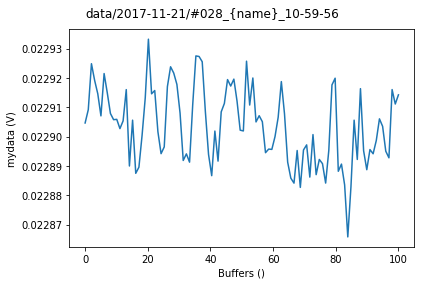

In [36]:
chan3d.num_averages(100)
chan3d.buffers_per_acquisition(100)
chan3d.alazar_channel('A')
chan3d.demod_freq(2e6)
chan3d.demod_type('magnitude')
alazar.buffer_timeout._set(10000)
alazar.buffer_timeout._set_updated()
chan3d.prepare_channel()

# Measure this 
data3 = qc.Measure(chan3d.data).run()
qc.MatPlot(data3.my_controller_myrecchan_d_data)
print(alazar.buffer_timeout())

c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#029_{name}_10-59-57'
   <Type>   | <array_id>                     | <array.name>                   | <array.shape>
   Setpoint | buffers_set                    | buffers                        | (100,)
   Measured | my_controller_myrecchan_data   | my_controller_myrecchan_data   | (100,)
   Measured | my_controller_myrecchan_d_data | my_controller_myrecchan_d_data | (100,)
acquired at 2017-11-21 10:59:58


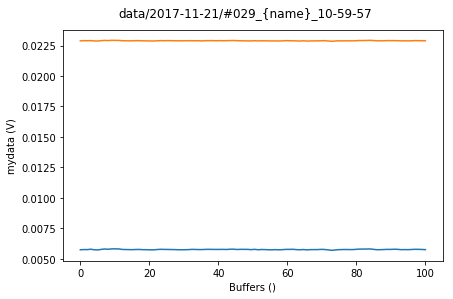

In [37]:
data = qc.Measure(myctrl.channels[-2:].data).run()
plot = qc.MatPlot()
plot.add(data.my_controller_myrecchan_data)
plot.add(data.my_controller_myrecchan_d_data)

# 2D Samples vs records

In [38]:
chan4 = AlazarChannel(myctrl, 'myrecvssamples', demod=False, average_records=False, integrate_samples=False)
myctrl.channels.append(chan4)

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#030_{name}_10-59-58'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_myrecvssamples_data | data         | (100, 4096)
acquired at 2017-11-21 11:00:03


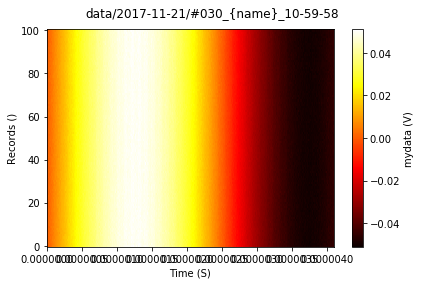

In [39]:
chan4.num_averages(1)
chan4.records_per_buffer(100)
chan4.alazar_channel('A')
chan4.prepare_channel()
# Measure this 
data4 = qc.Measure(chan4.data).run()
qc.MatPlot(data4.my_controller_myrecvssamples_data)

# 2D Buffers vs Records

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 72, 'buffers_per_acquisition': 10, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#031_{name}_11-00-04'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Measured | my_controller_mybuffersvsrecs_data | data         | (10, 72)
acquired at 2017-11-21 11:00:04
10000


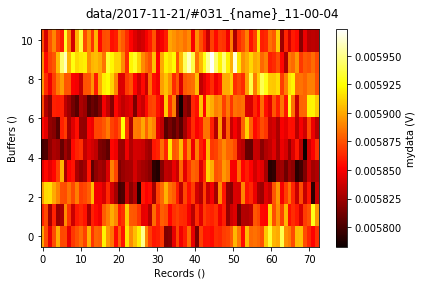

In [40]:
chan5 = AlazarChannel(myctrl, 'mybuffersvsrecs', demod=False, average_records=False, average_buffers=False)
alazar.buffer_timeout._set(10000)
chan5.records_per_buffer(72)
chan5.buffers_per_acquisition(10)
chan5.num_averages(1)
chan5.alazar_channel('A')
chan5.prepare_channel()
# Measure this
data5 = qc.Measure(chan5.data).run()
qc.MatPlot(data5.my_controller_mybuffersvsrecs_data)
print(alazar.buffer_timeout())

# 2D Buffers vs Samples

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#032_{name}_11-00-04'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Measured | my_controller_mybufvssamples_data | data         | (100, 4096)
acquired at 2017-11-21 11:00:10


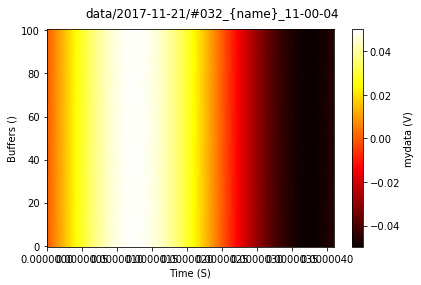

In [41]:
chan6 = AlazarChannel(myctrl, 'mybufvssamples', demod=False, average_buffers=False, integrate_samples=False)
chan6.buffers_per_acquisition(100)
chan6.num_averages(100)
chan6.alazar_channel('A')
chan6.prepare_channel()
# Measure this 
data6 = qc.Measure(chan6.data).run()
plot = qc.MatPlot(data6.my_controller_mybufvssamples_data)


# Single point

In [42]:
chan7 = AlazarChannel(myctrl, 'mybufvssamples', demod=False)


chan7.num_averages(100)
chan7.alazar_channel('A')
chan7.prepare_channel()
# Measure this

data7 = qc.Measure(chan7.data).run()

INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


DataSet:
   location = 'data/2017-11-21/#033_{name}_11-00-11'
   <Type>   | <array_id>                        | <array.name> | <array.shape>
   Setpoint | single_set                        | single       | (1,)
   Measured | my_controller_mybufvssamples_data | data         | (1,)
acquired at 2017-11-21 11:00:11


As we are not integrating over samples the setpoints (label, unit and ticks on number) are automatically set from the integration time and integration delay. **Note at the moment this does not cut of the int_delay from the plot. It probably should**

# Multiple channels

In [43]:
chan1 = AlazarChannel(myctrl, 'mychan1', demod=False, integrate_samples=False)
chan1.num_averages(1000)
chan1.alazar_channel('A')
chan1.prepare_channel()
chan2 = AlazarChannel(myctrl, 'mychan2', demod=False, integrate_samples=False)
chan2.num_averages(1000)
chan2.alazar_channel('B')
chan2.prepare_channel()
myctrl.channels.append(chan1)
myctrl.channels.append(chan2)


#plot = qc.MatPlot(data6.my_controller_mybufvssamples_data)

c:\users\jens\src\qcodes\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 4096, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared
INFO:qcodes.instrument_drivers.AlazarTech.ATS:buffers cleared


DataSet:
   location = 'data/2017-11-21/#034_{name}_11-00-11'
   <Type>   | <array_id>                 | <array.name>               | <array.shape>
   Setpoint | time_set                   | time                       | (4096,)
   Measured | my_controller_mychan1_data | my_controller_mychan1_data | (4096,)
   Measured | my_controller_mychan2_data | my_controller_mychan2_data | (4096,)
acquired at 2017-11-21 11:00:11


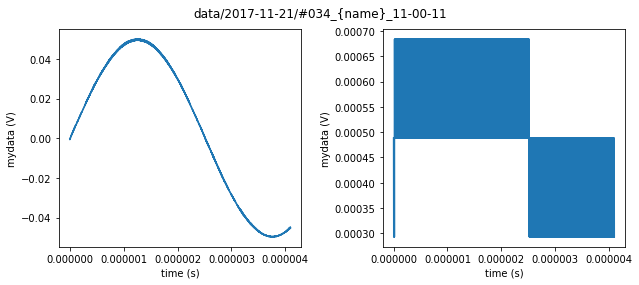

In [44]:
data7 = qc.Measure(myctrl.channels[-2:].data).run()
plot = qc.MatPlot(data7.my_controller_mychan1_data, data7.my_controller_mychan2_data)
